In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 
import sys
import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os
import importlib

In [47]:
import numpy as np
import pandas as pd

common_years = np.arange(2005, 2017)

# Lists to hold DataFrames for each dataset type
bm_dfs = []
v_y_dfs = []
v_x_dfs = []
sic_dfs = []
thickness_dfs = []
v_dfs = []

root = '/Users/francesco/Desktop/prove/'

for region in range(1, 29):  # Modify range(1, 29) if you have regions 1 to 28
    # Load bm data
    bm_file_path = root + f'bm_region_{region}.npy'
    bm_data = np.load(bm_file_path, allow_pickle=True)
    bm_df = pd.DataFrame(bm_data, index=[region], columns=common_years)
    bm_dfs.append(bm_df)
    
    # Load v_y data
    v_y_file_path = root + f'v_y_region_{region}.npy'
    v_y_data = np.load(v_y_file_path, allow_pickle=True)
    v_y_df = pd.DataFrame(v_y_data, index=[region], columns=common_years)
    v_y_dfs.append(v_y_df)
    
    # Load basal_melting data
    v_x_file_path = root + f'v_x_region_{region}.npy'
    v_x_data = np.load(v_x_file_path, allow_pickle=True)
    v_x_df = pd.DataFrame(v_x_data, index=[region], columns=common_years)
    v_x_dfs.append(v_x_df)
    
    # Load sic data
    sic_file_path = root + f'sic_region_{region}.npy'
    sic_data = np.load(sic_file_path, allow_pickle=True)
    sic_df = pd.DataFrame(sic_data, index=[region], columns=common_years)
    sic_dfs.append(sic_df)
    
    # Load thickness data
    thickness_file_path = root + f'thickness_region_{region}.npy'
    thickness_data = np.load(thickness_file_path, allow_pickle=True)
    thickness_df = pd.DataFrame(thickness_data, index=[region], columns=common_years)
    thickness_dfs.append(thickness_df)

    v_file_path = root + f'v_region_{region}.npy'
    v_data = np.load(v_file_path, allow_pickle=True)
    v_df = pd.DataFrame(v_data, index=[region], columns=common_years)
    v_dfs.append(v_df)

# Concatenate all DataFrames for each dataset type
bm = pd.concat(bm_dfs)
v_y = pd.concat(v_y_dfs)
v_x = pd.concat(v_x_dfs)
sic = pd.concat(sic_dfs)
thickness = pd.concat(thickness_dfs)
v = pd.concat(v_dfs)


In [65]:
#import the ice mask
ice_mask_dir = '/Users/francesco/Desktop/ice_mask.npy'
ice_mask = np.load(ice_mask_dir, allow_pickle=True)
ice_mask = pd.DataFrame(ice_mask, index=np.arange(1, 29), columns=common_years)

#set ice mask as int
for id in ice_mask.index:
    for year in ice_mask.columns:
        ice_mask.loc[id, year] = ice_mask.loc[id, year].astype(int)



In [80]:
mask_target = ice_mask.iloc[:, 1:] #Taking all the years from 2006 to 2016
mask_feature = ice_mask.iloc[:, :-1] #Taking all the years from 2005 to 2015

In [81]:
mask_feature.columns

Int64Index([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype='int64')

Normalize the dataset

In [49]:
#Finding the maximum to normalize the data

thickness_max = pd.DataFrame(index = bm.index, columns = common_years)
v_max = pd.DataFrame(index = bm.index, columns = common_years)
bm_max = pd.DataFrame(index = bm.index, columns = common_years)
bm_min = pd.DataFrame(index = bm.index, columns = common_years)

for year in common_years:
    for id in bm.index:

        thickness_max.loc[id,year] = thickness.loc[id,year].max()

        v_max.loc[id,year] = v.loc[id,year].max()

        bm_max.loc[id,year] = bm.loc[id,year].max()
        bm_min.loc[id,year] = bm.loc[id,year].min()



In [50]:
thickness_total_max = thickness_max.max().max()

v_total_max = v_max.max().max()

bm_total_max = bm_max.max().max()
bm_total_min = bm_min.min().min()

print('thickness_total_max', thickness_total_max)
print('velocity_total_max', v_total_max)
print('bm_total_max', bm_total_max, 'bm_total_min', bm_total_min)

thickness_total_max 4306.5547
velocity_total_max 4563.529043074536
bm_total_max 106.786 bm_total_min -276.62036


In [51]:
#Normaliing
v_x_normalized = v_x.copy()
v_y_normalized = v_y.copy()
v_normalized = v.copy()
thickness_normalized = thickness.copy()
bm_normalized = bm.copy()
sic_normalized = sic.copy()

for id in v.index:
    for year in common_years:
        v_x_normalized.loc[id,year] = v_x.loc[id,year] / v_total_max
        v_y_normalized.loc[id,year] = v_y.loc[id,year] / v_total_max
        v_normalized.loc[id,year] = v.loc[id,year] / v_total_max
        thickness_normalized.loc[id,year] = thickness.loc[id,year] / thickness_total_max
        bm_normalized.loc[id,year] = bm.loc[id,year] / (bm_total_max - bm_total_min)
        sic_normalized.loc[id,year] = sic.loc[id,year] / 100

In [58]:
#Save the dataset as numpy files here /Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn
saving_directory = '/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/' #CHANGE IN CLUSETER
np.save(saving_directory + 'bm_normalized.npy', bm_normalized)
np.save(saving_directory + 'v_x_normalized.npy', v_x_normalized)
np.save(saving_directory + 'v_y_normalized.npy', v_y_normalized)
np.save(saving_directory + 'v_normalized.npy', v_normalized)
np.save(saving_directory + 'thickness_normalized.npy', thickness_normalized)
np.save(saving_directory + 'sic_normalized.npy', sic_normalized)



In [ ]:
#Removing the lat year from all the datets
v_x_normalized = v_x_normalized.iloc[:, :-1]
v_y_normalized = v_y_normalized.iloc[:, :-1]
v_normalized = v_normalized.iloc[:, :-1]
thickness_normalized = thickness_normalized.iloc[:, :-1]
bm_normalized = bm_normalized.iloc[:, :-1]
sic_normalized = sic_normalized.iloc[:, :-1]

RESHAPING THE DATASET

In [101]:
window_size = 1024
n_regions = 28
n_feature_variables = 6
n_target_variables = 1
n_years = 11

In [102]:

#Input variables
stacked_arrays = np.stack([thickness_normalized.values, sic_normalized.values, v_x_normalized.values, v_y_normalized.values, bm_normalized.values, mask_feature.values], axis = -1)
stacked_arrays.shape #This is 128 ice shelves, 12 years and 5 variiables. Each of those element is 256x256

#Target variables
target = np.stack([mask_target.values], axis = -1)

stacked_arrays = np.reshape(stacked_arrays, (n_regions * n_years, n_feature_variables)) #28 regions, 12 years and 5 variiables. Each of those element is 1024x1024
target_mask = np.reshape(target, (n_regions * n_years, n_target_variables))

In [103]:
#Give shape (1536,1024,1024,6) to the features and (1536,256,256,1) to the target


features = np.zeros((n_regions*n_years,window_size,window_size,n_feature_variables))
target = np.zeros((n_regions*n_years,window_size,window_size,n_target_variables))

for i in range(n_regions*n_years):
    
        #Features
        t = stacked_arrays[i,0].flatten().reshape(window_size,window_size)
        s = stacked_arrays[i,1].flatten().reshape(window_size,window_size)
        vx = stacked_arrays[i,2].flatten().reshape(window_size,window_size)
        vy = stacked_arrays[i,3].flatten().reshape(window_size,window_size)
        bm = stacked_arrays[i,4].flatten().reshape(window_size,window_size)
        mask_feat = stacked_arrays[i,5].flatten().reshape(window_size,window_size)
    
        #target
        mask = target_mask[i,0].flatten().reshape(window_size,window_size)
    
        t = t[:,:,np.newaxis]
        s = s[:,:,np.newaxis]
        vx = vx[:,:,np.newaxis]
        vy = vy[:,:,np.newaxis]
        bm = bm[:,:,np.newaxis]
        mask_feat = mask_feat[:,:,np.newaxis]
    
        mask = mask[:,:,np.newaxis]

        test = np.concatenate((t,s,vx,vy,bm,mask_feat), axis = -1)
        target[i,:,:,:] = mask
    
        print('The round is', i, 'and the shape is', np.shape(test))
        features[i,:,:,:] = test

The round is 0 and the shape is (1024, 1024, 6)
The round is 1 and the shape is (1024, 1024, 6)
The round is 2 and the shape is (1024, 1024, 6)
The round is 3 and the shape is (1024, 1024, 6)
The round is 4 and the shape is (1024, 1024, 6)
The round is 5 and the shape is (1024, 1024, 6)
The round is 6 and the shape is (1024, 1024, 6)
The round is 7 and the shape is (1024, 1024, 6)
The round is 8 and the shape is (1024, 1024, 6)
The round is 9 and the shape is (1024, 1024, 6)
The round is 10 and the shape is (1024, 1024, 6)
The round is 11 and the shape is (1024, 1024, 6)
The round is 12 and the shape is (1024, 1024, 6)
The round is 13 and the shape is (1024, 1024, 6)
The round is 14 and the shape is (1024, 1024, 6)
The round is 15 and the shape is (1024, 1024, 6)
The round is 16 and the shape is (1024, 1024, 6)
The round is 17 and the shape is (1024, 1024, 6)
The round is 18 and the shape is (1024, 1024, 6)
The round is 19 and the shape is (1024, 1024, 6)
The round is 20 and the shape 

In [115]:
target.shape

(308, 1024, 1024, 1)

In [119]:
1433.6/60

23.89333333333333

In [112]:

# Check if the matrices are the same. It is working
are_equal = np.array_equal(target[0,:,:,0], ice_mask.loc[1,2006])

if are_equal:
    print("The matrices are the same.")
else:
    print("The matrices are different.")


The matrices are the same.


In [118]:
# Assuming dataset is your NumPy dataset of shape (700, 1024, 1024, 3)
dataset_size_bytes = features.nbytes

# Convert bytes to gigabytes
dataset_size_gigabytes = dataset_size_bytes / (1024 ** 3)

print("Total size of the dataset:", dataset_size_gigabytes, "GB")


Total size of the dataset: 14.4375 GB


In [121]:
#save them as numpy files
np.save(saving_directory + 'target.npy', target)
print('target saved')

np.save(saving_directory + 'features.npy', features)



target saved


In [122]:
#Load them
features = np.load(saving_directory + 'features.npy')
target = np.load(saving_directory + 'target.npy')



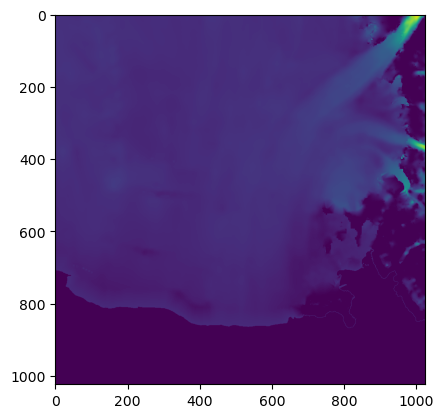